En este notebook se desarrollan los gráficos que se usarán en la parte de resultados del TFM

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from src.datasets import daocensus, daocensus_text, to_microsoft
from src import paths

In [2]:
ORG_NAME = 'Decentraland'
ORG_PLATFORM = 'snapshot'
USE_ORG_NAMES: bool = False
CUTOFF_DATE_STR: str = None
LAST_SPLITS = ... # Wont be used

SPLITS_FREQ = 'W-THU'
SPLITS_NORMALIZE: bool = True

In [3]:
# Parameters
ORG_NAME = "DEAD FoundationsDAO"
ORG_PLATFORM = "daohaus"
SPLITS_FREQ = "2d"
SPLITS_NORMALIZE = True
LAST_SPLITS = 10
USE_ORG_NAMES = True
EXECUTION_ID = "2024-03-21"
CUTOFF_DATE_STR = "2021-11-28"


In [4]:
CUTOFF_DATE = dt.datetime.fromisoformat(CUTOFF_DATE_STR) if CUTOFF_DATE_STR else None

# Exploración de datos de Decentraland

In [5]:
# dfptext = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
# dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, ORG_PLATFORM)
# dfv['voter'] = dfv['voter'].astype('str')
# dfp = dfp.merge(dfptext, how='left', left_on='platform_proposal', right_on='proposal_id')
# dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')
# dfp = dfp.set_index('id')
dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES, cutoff_date=CUTOFF_DATE)
dfp = dfp.set_index('id')
print(dfv.info())
print(dfp.info())

Warning, removing 16601 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16601 entries, 0 to 16600
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   platform       16601 non-null  object        
 1   name           16601 non-null  object        
 2   id             16601 non-null  object        
 3   proposal       16601 non-null  category      
 4   deployment     16601 non-null  object        
 5   platform_vote  16601 non-null  object        
 6   voter          16601 non-null  category      
 7   date           16601 non-null  datetime64[ns]
 8   choice         16601 non-null  object        
 9   weight         16601 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 1.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 5034 entries, 58b844b2-e739-5c96-a009-a3b81c138782 to de062f96-62b5-5982-91ff-46480fecf

## Cuantas propuestas tenemos para entrenar en el dataset

In [6]:
from src.model_selection import timeFreqSplitCurrent, filter_current
from collections import defaultdict

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in timeFreqSplitCurrent(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['t'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('t')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
sdf = sdf_all.tail(10)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

t
2021-11-06     9194
2021-11-08     9485
2021-11-10     9763
2021-11-12    10162
2021-11-14    10945
2021-11-16    12013
2021-11-18    12705
2021-11-20    13774
2021-11-22    14692
2021-11-24    15538
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
t,,,,,,,,,
2021-W44,44,242,95,5.50,2.55,27,13,0.61,2.08
2021-W45,217,248,65,1.14,3.82,170,50,0.78,3.40
2021-W45,216,268,79,1.24,3.39,189,48,0.88,3.94
2021-W45,264,365,91,1.38,4.01,202,47,0.77,4.30
2021-W45,516,748,163,1.45,4.59,341,55,0.66,6.20
2021-W46,505,981,238,1.94,4.12,211,55,0.42,3.84
2021-W46,305,614,174,2.01,3.53,165,52,0.54,3.17
2021-W46,384,896,271,2.33,3.31,80,38,0.21,2.11
2021-W47,420,921,270,2.19,3.41,73,34,0.17,2.15


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
t &  &  &  &  &  &  &  &  &  \\
2021-W44 & 44 & 242 & 95 & 5.50 & 2.55 & 27 & 13 & 0.61 & 2.08 \\
2021-W45 & 217 & 248 & 65 & 1.14 & 3.82 & 170 & 50 & 0.78 & 3.40 \\
2021-W45 & 216 & 268 & 79 & 1.24 & 3.39 & 189 & 48 & 0.88 & 3.94 \\
2021-W45 & 264 & 365 & 91 & 1.38 & 4.01 & 202 & 47 & 0.77 & 4.30 \\
2021-W45 & 516 & 748 & 163 & 1.45 & 4.59 & 341 & 55 & 0.66 & 6.20 \\
2021-W46 & 505 & 981 & 238 & 1.94 & 4.12 & 211 & 55 & 0.42 & 3.84 \\
2021-W46 & 305 & 614 & 174 & 2.01 & 3.53 & 165 & 52 & 0.54 & 3.17 \\
2021-W46 & 384 & 896 & 271 & 2.33 & 3.31 & 80 & 38 & 0.21 & 2.11 \\
2021-W47 & 420 & 921 & 270 & 2.19 & 3.41 & 73 & 34 & 0.17 & 2.15 \\
2021-W47 & 401 & 1179 & 344 & 2.94 & 3.

In [9]:
sdf.describe()

,open proposals,proposals in train,votes in train,votes in open proposals (train),users in open proposals (train),votes in test,users in train,users in test,vpp in open proposals (train),vpu in open proposals (train),vpp test,vpu test
count,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000
mean,327.200000,3667.60000,11827.100000,646.200000,179.000000,148.700000,2113.700000,41.10000,2.213782,3.615040,0.511132,3.270037
std,146.720293,791.12019,2280.446664,347.903499,97.483902,97.544349,446.031401,14.92537,1.283396,0.554916,0.281190,1.395051
min,44.000000,2732.00000,9194.000000,242.000000,65.000000,27.000000,1631.000000,13.00000,1.142857,2.547368,0.072319,1.526316
25%,228.750000,2976.50000,9862.750000,292.250000,92.000000,74.750000,1743.250000,35.00000,1.399335,3.397082,0.260705,2.115712
50%,344.500000,3580.50000,11479.000000,681.000000,168.500000,167.500000,2007.500000,47.50000,1.977845,3.478031,0.577310,3.286538
75%,415.250000,4234.00000,13506.750000,914.750000,262.000000,198.750000,2419.750000,51.50000,2.298214,3.962088,0.739077,3.912216
max,516.000000,4930.00000,15538.000000,1179.000000,344.000000,341.000000,2888.000000,55.00000,5.500000,4.588957,0.875000,6.200000


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '2021-W44'),
  Text(1, 0, '2021-W45'),
  Text(2, 0, '2021-W45'),
  Text(3, 0, '2021-W45'),
  Text(4, 0, '2021-W45'),
  Text(5, 0, '2021-W46'),
  Text(6, 0, '2021-W46'),
  Text(7, 0, '2021-W46'),
  Text(8, 0, '2021-W47'),
  Text(9, 0, '2021-W47')])

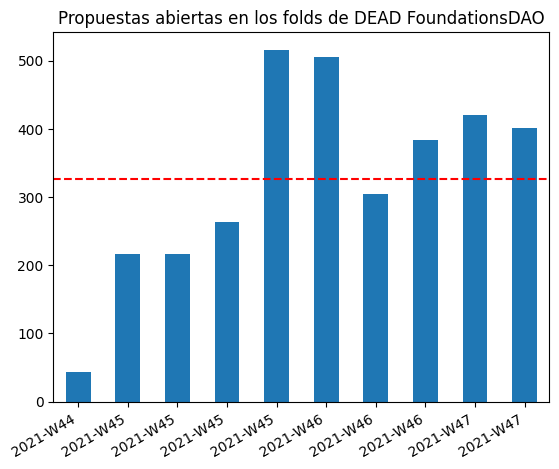

In [10]:
ax = sdf[['open proposals']].plot.bar(legend=False, xlabel='')
plt.axhline(sdf['open proposals'].mean(), c='red', linestyle='--')
ax.set_title(f'Propuestas abiertas en los folds de {ORG_NAME}')
ax.set_xticklabels(sdf.index.strftime('%G-W%V'))
plt.xticks(rotation=30, ha='right')
# TODO: Pintar horizonte con la media

<Axes: xlabel='t'>

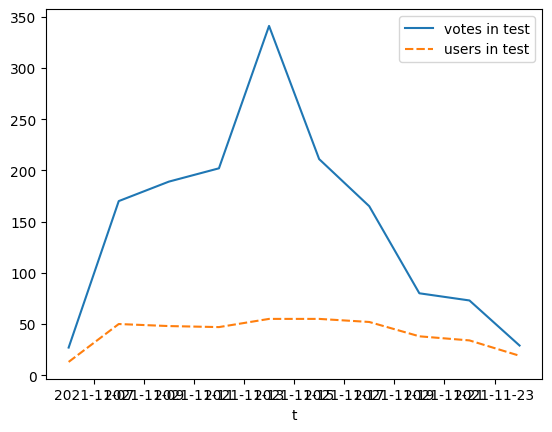

In [11]:
sns.lineplot(sdf[[
    # 'users in train (filtered)', 'votes in train (filtered)', 
    'votes in test', 'users in test',
]])

### Numero de propuestas relevantes
Además del número de propuestas abiertas, queremos saber cual es la _precision@k_ máxima, para ello es necesario saber no sólo el número de propuestas abiertas, si no en cuantas de esas propuestas votaron los usuarios. En términos de IR, necesitamos saber cual es el número de documentos relevantes, que seguramente sea menor que el número de documentos recuperados.

In [12]:
sdf['vpu in test'] = sdf['votes in test'] / sdf['users in test']
sdf

/tmp/ipykernel_3724596/710207913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['vpu in test'] = sdf['votes in test'] / sdf['users in test']


,open proposals,proposals in train,votes in train,votes in open proposals (train),users in open proposals (train),votes in test,users in train,users in test,vpp in open proposals (train),vpu in open proposals (train),vpp test,vpu test,vpu in test
t,,,,,,,,,,,,,
2021-11-06,44,2732,9194,242,95,27,1631,13,5.500000,2.547368,0.613636,2.076923,2.076923
2021-11-08,217,2847,9485,248,65,170,1676,50,1.142857,3.815385,0.783410,3.400000,3.400000
2021-11-10,216,2939,9763,268,79,189,1726,48,1.240741,3.392405,0.875000,3.937500,3.937500
2021-11-12,264,3089,10162,365,91,202,1795,47,1.382576,4.010989,0.765152,4.297872,4.297872
2021-11-14,516,3393,10945,748,163,341,1902,55,1.449612,4.588957,0.660853,6.200000,6.200000
2021-11-16,505,3768,12013,981,238,211,2113,55,1.942574,4.121849,0.417822,3.836364,3.836364
2021-11-18,305,3985,12705,614,174,165,2251,52,2.013115,3.528736,0.540984,3.173077,3.173077
2021-11-20,384,4317,13774,896,271,80,2476,38,2.333333,3.306273,0.208333,2.105263,2.105263
2021-11-22,420,4676,14692,921,270,73,2679,34,2.192857,3.411111,0.173810,2.147059,2.147059


# Recomendador GNN

In [13]:
dfh = pd.read_csv(paths.hybrid_results(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, cutoff_date=CUTOFF_DATE))
dfg = dfh[dfh['model'] == 'gnn'].reset_index(drop=True)
dfg

,t,merge,map@10,map@5,ndcg@10,ndcg@5,precision@10,precision@5,recall@10,recall@5,model
0,2021-11-06,-,0.118173,0.094872,0.146087,0.116774,0.053846,0.046154,0.217949,0.166667,gnn
1,2021-11-08,-,0.021894,0.021064,0.043556,0.044882,0.022000,0.028000,0.031915,0.031064,gnn
2,2021-11-10,-,0.025637,0.021747,0.048611,0.041667,0.025000,0.025000,0.043494,0.021747,gnn
3,2021-11-12,-,0.002149,0.001075,0.021277,0.021277,0.021277,0.021277,0.002149,0.001075,gnn
4,2021-11-14,-,0.046910,0.046405,0.063232,0.059955,0.021818,0.021818,0.047846,0.046509,gnn
5,2021-11-16,-,0.001737,0.000449,0.016419,0.012015,0.018182,0.014545,0.006033,0.000661,gnn
6,2021-11-18,-,0.090118,0.080309,0.127753,0.112531,0.042308,0.053846,0.172185,0.143506,gnn
7,2021-11-20,-,0.017864,0.017544,0.030122,0.026316,0.010526,0.010526,0.054276,0.052632,gnn
8,2021-11-22,-,0.005310,0.000000,0.014195,0.000000,0.005882,0.000000,0.039216,0.000000,gnn
9,2021-11-24,-,0.026316,0.026316,0.033207,0.033207,0.005263,0.010526,0.052632,0.052632,gnn


# Recomendador Híbrido

In [14]:
from src import baseline

# dfm_baseline = pd.read_csv(f'./data/baseline/mp-freq-{ORG_NAME}-{SPLITS_FREQ}.csv')
dfm_baseline = baseline.read_metrics_baseline(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, cutoff_date = CUTOFF_DATE)
dfm_baseline['model'] = 'mp'
dfm_all = pd.read_csv(paths.hybrid_results(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, cutoff_date=CUTOFF_DATE)).set_index('t')
dfm_all = pd.concat((dfm_all, dfm_baseline))
dfm_all

,merge,map@10,map@5,ndcg@10,ndcg@5,precision@10,precision@5,recall@10,recall@5,model,precision@15,ndcg@15,map@15,recall@15
t,,,,,,,,,,,,,,
2021-11-06,avg,0.088105,0.026496,0.143460,0.057900,0.069231,0.046154,0.282051,0.115385,hybrid,NaN,NaN,NaN,NaN
2021-11-08,avg,0.015628,0.009730,0.042117,0.034744,0.026000,0.028000,0.042128,0.031064,hybrid,NaN,NaN,NaN,NaN
2021-11-10,avg,0.010855,0.005080,0.037272,0.028893,0.025000,0.025000,0.043494,0.021747,hybrid,NaN,NaN,NaN,NaN
2021-11-12,avg,0.003401,0.001075,0.028914,0.021277,0.025532,0.021277,0.003401,0.001075,hybrid,NaN,NaN,NaN,NaN
2021-11-14,avg,0.005706,0.010777,0.030904,0.039619,0.021818,0.032727,0.051525,0.051243,hybrid,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-19 21:41:10,NaN,0.025568,0.025568,0.033075,0.033075,0.005682,0.011364,0.051136,0.051136,mp,0.003788,0.033075,0.025568,0.051136
2021-11-21 23:14:25,NaN,0.033592,0.031008,0.042335,0.038245,0.009302,0.013953,0.063953,0.054264,mp,0.006202,0.042335,0.033592,0.063953
2021-11-23 23:06:00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,mp,0.000000,0.000000,0.000000,0.000000
